In [1]:
# Familiar imports
import numpy as np
import pandas as pd
import random
import os
import time
from pathlib import Path
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet

from scipy.optimize import minimize

#import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'loss'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 17
    CVSEED = 17
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 10000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 17
    CVSEED = 17
    #N_ITERS = 10

In [3]:
def set_seed(seed=17):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Load data

In [4]:
INPUT = Path("../input/tabular-playground-series-aug-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
train['lgb_pred'] = np.load("../input/tps-aug-2021-stacking/lgb_oof.npy")
test['lgb_pred'] = np.load("../input/tps-aug-2021-stacking/lgb_pred.npy")

train['rr_pred'] = np.load("../input/model-loading-tps-aug-2021-stacking-rf/rr_oof.npy")
test['rr_pred'] = np.load("../input/model-loading-tps-aug-2021-stacking-rf/rr_pred.npy")

train['mlp_pred'] = np.load("../input/tps-aug-stacking-mlp-pred/1mlp_oof.npy")+np.load("../input/tps-aug-stacking-mlp-pred/2mlp_oof.npy")+np.load("../input/tps-aug-stacking-mlp-pred/3mlp_oof.npy")
test['mlp_pred'] = np.load("../input/tps-aug-stacking-mlp-pred/1mlp_pred.npy")+np.load("../input/tps-aug-stacking-mlp-pred/2mlp_pred.npy")+np.load("../input/tps-aug-stacking-mlp-pred/3mlp_pred.npy")

train['xgbl2_pred'] = np.load("../input/tps-aug-xgb-lv2-pred/1xgb_oof.npy")+np.load("../input/tps-aug-xgb-lv2-pred/2xgb_oof.npy")
test['xgbl2_pred'] = np.load("../input/tps-aug-xgb-lv2-pred/1xgb_pred.npy")+np.load("../input/tps-aug-xgb-lv2-pred/2xgb_pred.npy")


# Preprocessing

In [6]:
scale_features = [col for col in test.columns if 'pred' in col]

ss = StandardScaler()
train[scale_features] = ss.fit_transform(train[scale_features])
test[scale_features] = ss.transform(test[scale_features])

In [7]:
# Swap noise

# Random
def apply_noise_rn(df, p=.75):
    should_not_swap = np.random.binomial(1, p, df.shape)
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Row-wise
def apply_noise_row(df, p=.75):
    should_not_swap = np.zeros(df.shape)
    for i in range(df.shape[0]):
        for j in np.random.choice(df.shape[1],int(p*df.shape[1]),replace=False):
            should_not_swap[i,j]=1 
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Pseudo Label

In [8]:
pseudo = pd.read_csv("../input/blending-tool-tps-aug-2021/file1_7.84987_file2_7.84996_blend.csv")[target]
test_pseudo = pd.concat([test, pseudo], axis=1)
all_pseudo = pd.concat([train, test_pseudo]).reset_index(drop=True)

In [9]:
useful_features = scale_features

# EN

In [10]:
en_params  = {
                 
               'max_iter':N_ESTIMATORS,
    
                'alpha': 0.018982240369176395, 
                'l1_ratio': 0.8055028430485707,
                'selection': 'random'

                }

In [11]:
en_oof = np.zeros(train.shape[0])
en_pred = np.zeros(test.shape[0])
en_importances = pd.DataFrame()


kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED, SEED+1, SEED+2]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=all_pseudo[useful_features], y=all_pseudo[target])):
    print(f"===== fold {fold} =====")
    
    #if fold in [7,8,9]:
        
    oof_idx = np.array([idx for idx in val_idx if idx < train.shape[0]])
    preds_idx = np.array([idx for idx in val_idx if idx >= train.shape[0]])

    X_train, y_train = all_pseudo[useful_features].iloc[trn_idx], all_pseudo[target].iloc[trn_idx]
    #X_train = apply_noise_row(X_train)

    X_valid, y_valid = all_pseudo[useful_features].iloc[oof_idx], all_pseudo[target].iloc[oof_idx]
    X_test = all_pseudo[useful_features].iloc[preds_idx]

    # en
    start = time.time()

    for inseed in seed_list:
        
        en_params2 = en_params.copy()
        en_params2['random_state'] = inseed

        model = ElasticNet(**en_params2, warm_start=True)
        model.fit(
            X_train, 
            y_train,

        )
        
        #en_params2['reg_lambda'] *= 0.9
        en_params2['alpha'] *= 0.9
        #en_params2['learning_rate'] *= 0.1
        #model = ElasticNet(**en_params2, warm_start=True)
        model.fit(
                X_train, y_train,
                
        )    

        with open(f"en_model{fold}.pkl", 'wb') as f:
            pickle.dump(model, f)


        en_oof[oof_idx] += model.predict(X_valid) / len(seed_list)
        en_pred[preds_idx-train.shape[0]] += model.predict(X_test) / len(seed_list)
        model = None

    elapsed = time.time() - start
    rmse = mean_squared_error(y_valid, en_oof[oof_idx], squared=False)
    print(f"fold {fold} - en rmse: {rmse:.6f}, elapsed time: {elapsed:.2f}sec\n")

        
print(f"oof en_rmse = {mean_squared_error(train[target], en_oof, squared=False)}")

np.save("en_oof.npy", en_oof)
np.save("en_pred.npy", en_pred)

===== fold 0 =====
fold 0 - en rmse: 7.764694, elapsed time: 1.16sec

===== fold 1 =====
fold 1 - en rmse: 7.722211, elapsed time: 1.05sec

===== fold 2 =====
fold 2 - en rmse: 7.817236, elapsed time: 0.96sec

===== fold 3 =====
fold 3 - en rmse: 7.767626, elapsed time: 1.05sec

===== fold 4 =====
fold 4 - en rmse: 7.773216, elapsed time: 1.04sec

===== fold 5 =====
fold 5 - en rmse: 7.830406, elapsed time: 1.05sec

===== fold 6 =====
fold 6 - en rmse: 7.872504, elapsed time: 1.10sec

===== fold 7 =====
fold 7 - en rmse: 7.872209, elapsed time: 1.04sec

===== fold 8 =====
fold 8 - en rmse: 7.858995, elapsed time: 1.03sec

===== fold 9 =====
fold 9 - en rmse: 7.836007, elapsed time: 1.03sec

oof en_rmse = 7.811702068473641


# OOF predictions

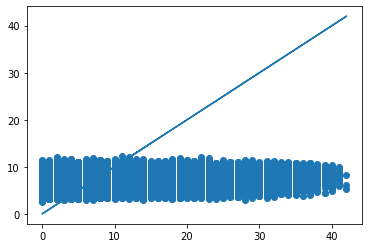

In [12]:
plt.plot(train[target], train[target])
plt.scatter(train[target], en_oof)

# Submission

In [13]:
submission[target] = en_pred
submission.to_csv("submission.csv", index=False)

submission

,id,loss
0,250000,7.993819
1,250001,5.154852
2,250002,9.003498
3,250003,7.891432
4,250004,6.749863
...,...,...
149995,399995,8.429028
149996,399996,7.829842
149997,399997,6.012020
149998,399998,5.216781
